In [1]:
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
import pathlib
import json
import glob
from collections import defaultdict

In [4]:
experiment_name = 'lottery_1a33bed04f87d8f96b8774aebc4aa8d6' # lottery_snipvgg11old
basepath = os.path.join('/home/levaid/bigstorage/open_lth_data', experiment_name)

hparams = pathlib.Path(os.path.join(basepath, 'replicate_1', 'level_0/main/hparams.log')).read_text()
print(hparams)


Dataset Hyperparameters
    * dataset_name => cifar10
    * batch_size => 128
    * do_not_augment => True
Model Hyperparameters
    * model_name => cifar_vgg_11
    * model_init => kaiming_normal
    * batchnorm_init => uniform
Pruning Hyperparameters
    * pruning_strategy => snip_global
    * pruning_fraction => 0.5
Training Hyperparameters
    * optimizer_name => sgd
    * lr => 0.1
    * training_steps => 60ep
    * momentum => 0.1
    * milestone_steps => 40ep
    * gamma => 0.1
    * weight_decay => 0.0001


In [2]:
from matplotlib import rc, rcParams
# rc('font',**{'family':['serif'],'serif':['Computer Modern Roman']})
rc('font', **{'family':'serif','serif':'Computer Modern'})
rc('text', usetex=True)

In [5]:
def create_df_from_experiment(experiment_name, pruning_strat):
    df_data = []
    basepath = os.path.join('/home/levaid/bigstorage/open_lth_data', experiment_name)
    for replicate_id in sorted(os.listdir(basepath)):
        # data[replicate_id] = {}
        for level in os.listdir(os.path.join(basepath, replicate_id)):
            
            

            try:
                if level == 'level_posttrain':
                    accuracies = pd.read_csv(os.path.join(basepath, replicate_id, level, 'main', 'logger'), names = ['measure', 'unk', 'perf'])
                    top_accuracy = accuracies.query('measure == "test_accuracy"')['perf'].max()
                    df_data += [(replicate_id, level, top_accuracy, -1, pruning_strat)]
                    continue
                
                accuracies = pd.read_csv(os.path.join(basepath, replicate_id, level, 'main', 'logger'), names = ['measure', 'unk', 'perf'])
                with open(os.path.join(basepath, replicate_id, level, 'main', 'sparsity_report.json')) as f:
                    pruning_report = json.load(f)
                top_accuracy = accuracies.query('measure == "test_accuracy"')['perf'].max()
                pruning_percent = pruning_report['unpruned'] / pruning_report['total']
                #data[replicate_id][level] = {'accuracy': top_accuracy, 'unpruned': pruning_percent}
                # data[replicate_id][level] = top_accuracy, pruning_percent
                df_data += [(replicate_id, level, top_accuracy, round(pruning_percent, ndigits=3), pruning_strat)]

            except:
                print(replicate_id, level)
                
            
                
    df = pd.DataFrame(df_data, columns = ['replicate_id', 'level', 'accuracy', 'unpruned', 'pruning_strategy'])
    return(df)

In [4]:
def create_df_from_init_experiments(model_name):
    
    prettify_dict = {'snip_vgg11': 'SNIP_init',
                     'sparse_vgg11': 'sparse_init',
                     'snip_vgg16': 'SNIP_init',
                     'sparse_vgg16': 'sparse_init',
                     'snip_resnet20': 'SNIP_init',
                     'sparse_resnet20': 'sparse_init'}
    init_df_data = []
    init_basepath = '/home/levaid/bigstorage/open_lth_data'
    experiments = [folder for folder in os.listdir(init_basepath) if model_name in folder]
    print(experiments)
    for experiment_name in experiments:
        for level in [l for l in os.listdir(os.path.join(init_basepath, experiment_name)) if 'perf' in l]:
            accuracies = pd.read_csv(os.path.join(init_basepath, experiment_name, level), names = ['measure', 'unk', 'perf'])[1:]
            top_accuracy = accuracies.query('measure == "test_accuracy"')['perf'].max()
            pruning_percent = (1/2) ** int(level.split('_')[1])
            init_df_data += [(experiment_name, f'level_{level.split("_")[1]}', 
                         top_accuracy, round(pruning_percent, ndigits=3),
                         prettify_dict['_'.join(experiment_name.split('_')[-2:])] )]

    init_df = pd.DataFrame(init_df_data, columns = ['replicate_id', 'level', 'accuracy', 'unpruned', 'pruning_strategy'])

    return(init_df)

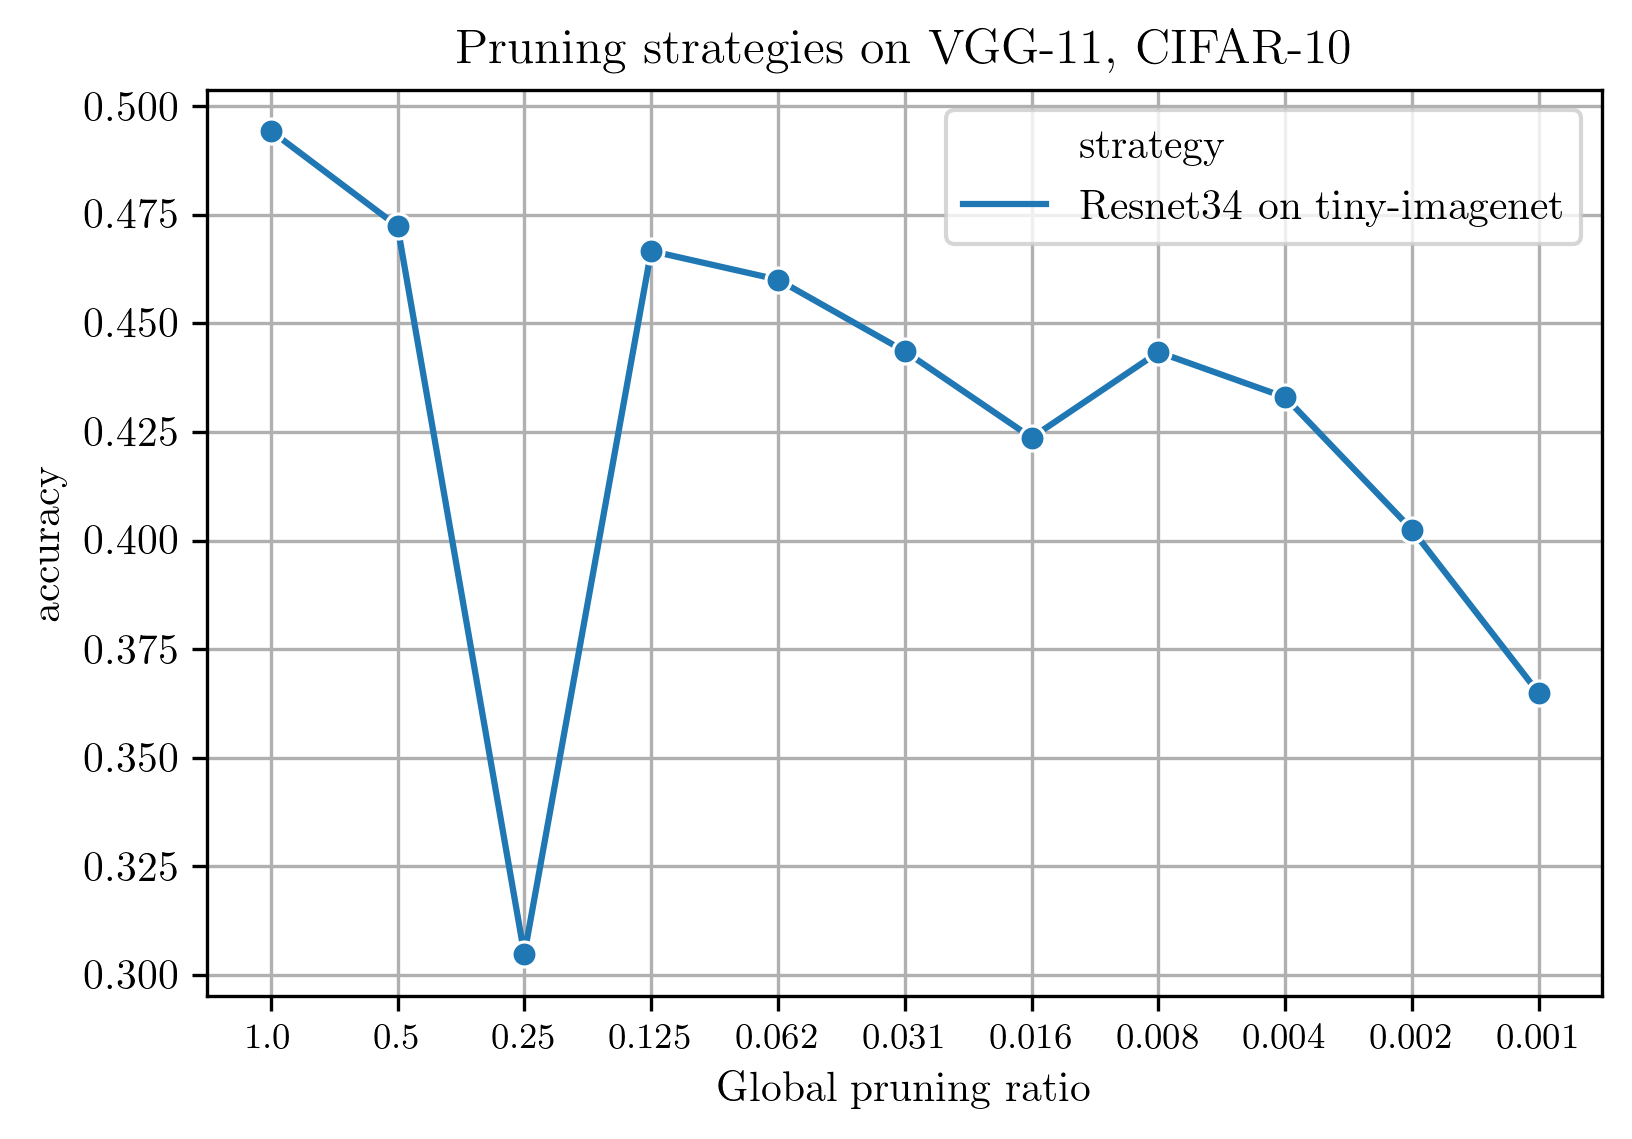

In [18]:
dfs = []

dfs.append(create_df_from_experiment('lottery_b3b7f61e9c219199cf6e3dbf9abf6499', 'Resnet34 on tiny-imagenet'))

# snip_init_df = create_df_from_init_experiments('snip_vgg11_newgrad')
# sparse_init_df = create_df_from_init_experiments('snip_vgg11_oldgrad')
# df = snip_df.append(sparse_df).append(snip_init_df).append(sparse_init_df).query('unpruned > 0.007')
df = pd.concat(dfs)
# df['schedule'] = df['pruning_strategy'].apply(lambda row: 'train' if 'LTH' in row else 'init')
# df['strategy'] = df['pruning_strategy'].apply(lambda row: 'weight*grad' if 'SNIP' in row else 'weight')
df['strategy'] = df['pruning_strategy']

plt.figure(figsize=(6,4), facecolor='white', dpi=300)
plt.tight_layout()
ax = sns.lineplot(x="level", y="accuracy", data=df, hue='strategy', marker = 'o')
ax.set_xticklabels([str(x) for x in sorted(df['unpruned'].unique(), reverse=True)])
ax.set_title('Pruning strategies on VGG-11, CIFAR-10')
ax.set_xlabel('Global pruning ratio')
# ax.set_xlim((0,9))
# ax.set_ylim((0.75, 0.82))
#ax.set_xticks(sorted(ax.get_xticks(), reverse=True))
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize('small')
ax.grid()

In [9]:
snip_df

,replicate_id,level,accuracy,unpruned,pruning_strategy
0,replicate_1,level_2,0.8136,0.250,Gradient collect at the end
1,replicate_1,level_0,0.8145,1.000,Gradient collect at the end
2,replicate_1,level_7,0.7885,0.008,Gradient collect at the end
3,replicate_1,level_8,0.7748,0.004,Gradient collect at the end
4,replicate_1,level_3,0.8112,0.125,Gradient collect at the end
...,...,...,...,...,...
74,replicate_8,level_3,0.8094,0.125,Gradient collect at the end
75,replicate_8,level_1,0.8117,0.500,Gradient collect at the end
76,replicate_8,level_4,0.8043,0.062,Gradient collect at the end
77,replicate_8,level_6,0.7925,0.016,Gradient collect at the end


In [123]:
sparse_init_df.query("level == 'level_4'")

,replicate_id,level,accuracy,unpruned,pruning_strategy
1,2020_06_21_17_58_11_sparse_vgg16,level_4,0.7877,0.062,sparse_init
9,2020_06_22_03_17_41_sparse_vgg16,level_4,0.8025,0.062,sparse_init
16,2020_06_21_20_19_10_sparse_vgg16,level_4,0.8028,0.062,sparse_init


['2020_06_21_20_58_07_snip_resnet20', '2020_06_22_02_53_21_snip_resnet20', '2020_06_21_23_55_57_snip_resnet20', '2020_06_21_14_59_10_snip_resnet20', '2020_06_21_17_56_26_snip_resnet20']
['2020_06_21_20_57_58_sparse_resnet20', '2020_06_22_02_51_34_sparse_resnet20', '2020_06_21_15_01_20_sparse_resnet20', '2020_06_21_23_53_42_sparse_resnet20', '2020_06_21_17_59_44_sparse_resnet20']


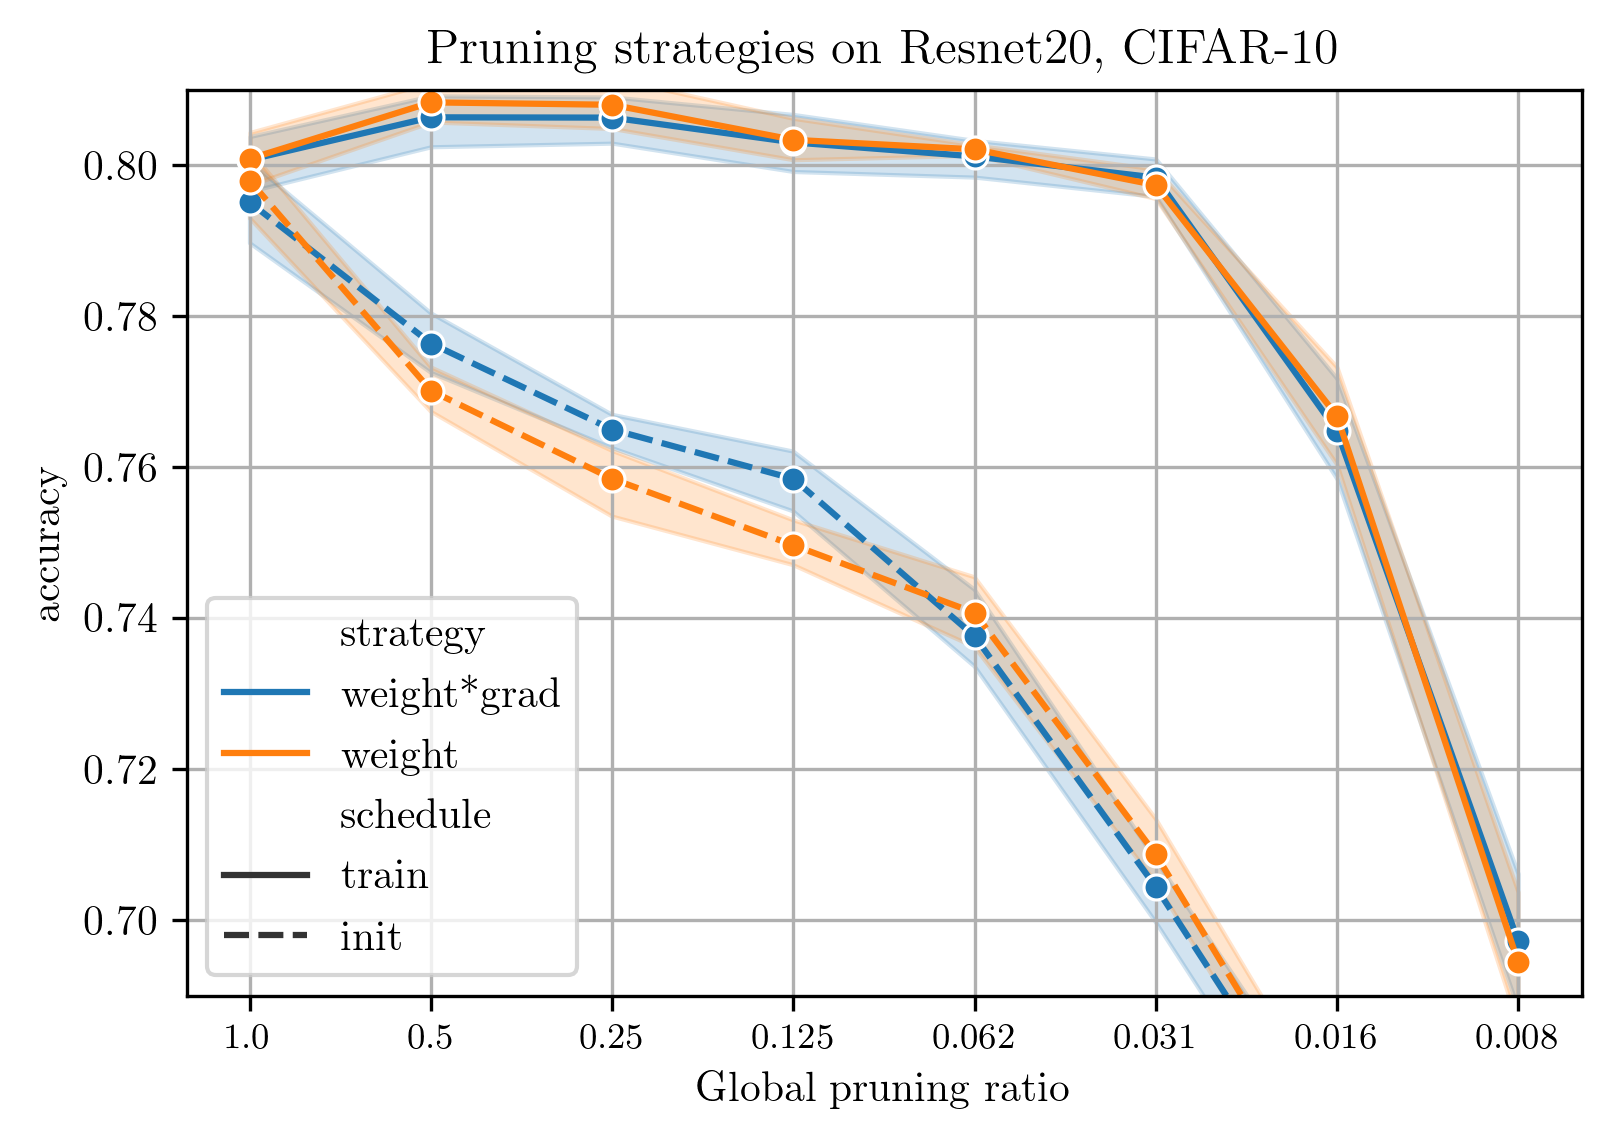

In [10]:
snip_df = create_df_from_experiment('lottery_e6dc86114120217d26411ed6aa033318', 'SNIP global LTH')
sparse_df = create_df_from_experiment('lottery_31ef6d1c09469a516b6742d9fe99305e', 'sparse global LTH')
snip_init_df = create_df_from_init_experiments('snip_resnet20')
sparse_init_df = create_df_from_init_experiments('sparse_resnet20')
df = snip_df.append(sparse_df).append(snip_init_df).append(sparse_init_df).query('unpruned > 0.007')
df['schedule'] = df['pruning_strategy'].apply(lambda row: 'train' if 'LTH' in row else 'init')
df['strategy'] = df['pruning_strategy'].apply(lambda row: 'weight*grad' if 'SNIP' in row else 'weight')

plt.figure(figsize=(6,4), facecolor='white', dpi=300)
plt.tight_layout()
ax = sns.lineplot(x="level", y="accuracy", data=df, style = 'schedule', hue='strategy', marker = 'o')
ax.set_xticklabels([str(x) for x in sorted(df['unpruned'].unique(), reverse=True)])
ax.set_title('Pruning strategies on Resnet20, CIFAR-10')
ax.set_xlabel('Global pruning ratio')
# ax.set_xlim((0,9))
ax.set_ylim((0.69, 0.81))
#ax.set_xticks(sorted(ax.get_xticks(), reverse=True))
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize('small')
ax.grid()

In [19]:
experiment_name = 'lottery_1a33bed04f87d8f96b8774aebc4aa8d6' # lottery_snipvgg11old
basepath = os.path.join('/home/levaid/bigstorage/open_lth_data', experiment_name)

hparams = pathlib.Path(os.path.join(basepath, 'replicate_1', 'level_0/main/hparams.log')).read_text()
print(hparams)


Dataset Hyperparameters
    * dataset_name => cifar10
    * batch_size => 128
    * do_not_augment => True
Model Hyperparameters
    * model_name => cifar_vgg_11
    * model_init => kaiming_normal
    * batchnorm_init => uniform
Pruning Hyperparameters
    * pruning_strategy => snip_global
    * pruning_fraction => 0.5
Training Hyperparameters
    * optimizer_name => sgd
    * lr => 0.1
    * training_steps => 60ep
    * momentum => 0.1
    * milestone_steps => 40ep
    * gamma => 0.1
    * weight_decay => 0.0001


In [6]:

glob.glob(open_lth_data_path + '*')
ex = 'lottery_c3cf3b3877f61b4c12643d8d7d78e549'

In [7]:
dets = H.get_hparams_from_experiment(ex, open_lth_data_path, [])
print(dets)

NameError: name 'get_hparams_from_experiment' is not defined

In [3]:
import helper_functions as H
open_lth_data_path = '/home/levaid/bigstorage/open_lth_data/'

In [149]:
dfs = []
names_dic = {}
for ex in os.listdir(open_lth_data_path):
    if ex == 'old_experiments_pre_sept':
        continue
    try:
        model_name, pruning_strategy, levels, fraction, *epochs = H.get_hparams_from_experiment(ex, open_lth_data_path, ['model_name', 'pruning_strategy', 'pruning_levels', 'pruning_fraction', 'training_steps'])
    except (IndexError, FileNotFoundError):
        print(ex)
        continue
    if model_name == 'cifar_resnet_20':
        results = create_df_from_experiment(ex, pruning_strategy)
        results['epochs_per_level'] = H.convert_epoch_iter(epochs[-1], to='ep', its_per_epoch=390.25)
        results['experiment_name'] = ex
        results['levels'] = levels-1
        results['fraction'] = float(fraction)
        dfs += [results]

replicate_1 level_0
replicate_2 level_0
replicate_3 level_posttrain
replicate_4 level_posttrain
lottery_27fc08cb263fb1c85f3b2ff9458b0590
lottery_26e831abdc0afe58888dfeb9ada6b947
replicate_2 level_6
replicate_2 level_5
replicate_2 level_7
replicate_2 level_posttrain
replicate_2 level_8
replicate_2 level_4
replicate_2 level_9
replicate_2 level_3
replicate_3 level_6
replicate_3 level_5
replicate_3 level_7
replicate_3 level_posttrain
replicate_3 level_11
replicate_3 level_10
replicate_3 level_8
replicate_3 level_1
replicate_3 level_2
replicate_3 level_4
replicate_3 level_9
replicate_3 level_3
replicate_3 level_0
replicate_4 level_6
replicate_4 level_5
replicate_4 level_7
replicate_4 level_posttrain
replicate_4 level_11
replicate_4 level_10
replicate_4 level_8
replicate_4 level_1
replicate_4 level_2
replicate_4 level_4
replicate_4 level_9
replicate_4 level_3
replicate_4 level_0
replicate_3 level_posttrain
replicate_4 level_posttrain
replicate_1 level_3
replicate_2 level_3


In [151]:
df_unfiltered = pd.concat(dfs).query('fraction >= 0.45 and levels != -1')

df_unfiltered['pruning_strategy'] = df_unfiltered['pruning_strategy'].apply(lambda s: s.replace('_', ' '))
df_unfiltered['strategy'] = df_unfiltered['pruning_strategy'].apply(lambda s: 'w*g' if s == 'snip global' else 'w')
df_unfiltered['iters_per_level'] = df_unfiltered['epochs_per_level'] * 391
df_unfiltered

,replicate_id,level,accuracy,unpruned,pruning_strategy,epochs_per_level,experiment_name,levels,fraction,strategy,iters_per_level
0,replicate_1,level_posttrain,0.8403,-1.00,sparse global,2.0,lottery_1bdc9ff7a8eb9edb678ef509ba809a04,1,0.5,w,782.0
1,replicate_1,level_1,0.7288,0.50,sparse global,2.0,lottery_1bdc9ff7a8eb9edb678ef509ba809a04,1,0.5,w,782.0
2,replicate_1,level_0,0.6934,1.00,sparse global,2.0,lottery_1bdc9ff7a8eb9edb678ef509ba809a04,1,0.5,w,782.0
3,replicate_2,level_posttrain,0.8457,-1.00,sparse global,2.0,lottery_1bdc9ff7a8eb9edb678ef509ba809a04,1,0.5,w,782.0
4,replicate_2,level_1,0.7490,0.50,sparse global,2.0,lottery_1bdc9ff7a8eb9edb678ef509ba809a04,1,0.5,w,782.0
...,...,...,...,...,...,...,...,...,...,...,...
11,replicate_3,level_0,0.7827,1.00,sparse global,5.0,lottery_3bd1eceeb1d659e69210c530f9b78844,2,0.5,w,1955.0
12,replicate_4,level_posttrain,0.8374,-1.00,sparse global,5.0,lottery_3bd1eceeb1d659e69210c530f9b78844,2,0.5,w,1955.0
13,replicate_4,level_1,0.8057,0.50,sparse global,5.0,lottery_3bd1eceeb1d659e69210c530f9b78844,2,0.5,w,1955.0
14,replicate_4,level_2,0.8119,0.25,sparse global,5.0,lottery_3bd1eceeb1d659e69210c530f9b78844,2,0.5,w,1955.0


In [152]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    break
    display(df_unfiltered.query("level == 'level_1'"))



SyntaxError: 'break' outside loop (<ipython-input-152-eade0add2bf5>, line 5)

In [153]:
baseline_nopruning_df = df_unfiltered.query("unpruned == 1.0 and level == 'level_0' and epochs_per_level == 60")
baseline_nopruning_df['strategy'] = 'no pruning\nat 60ep'
helper_df = baseline_nopruning_df.copy()
helper_df['epochs_per_level'] = 0
baseline_nopruning_df = baseline_nopruning_df.append(helper_df)
baseline_nopruning_df['levels'] = 1

/home/levaid/.miniconda3/envs/torchenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


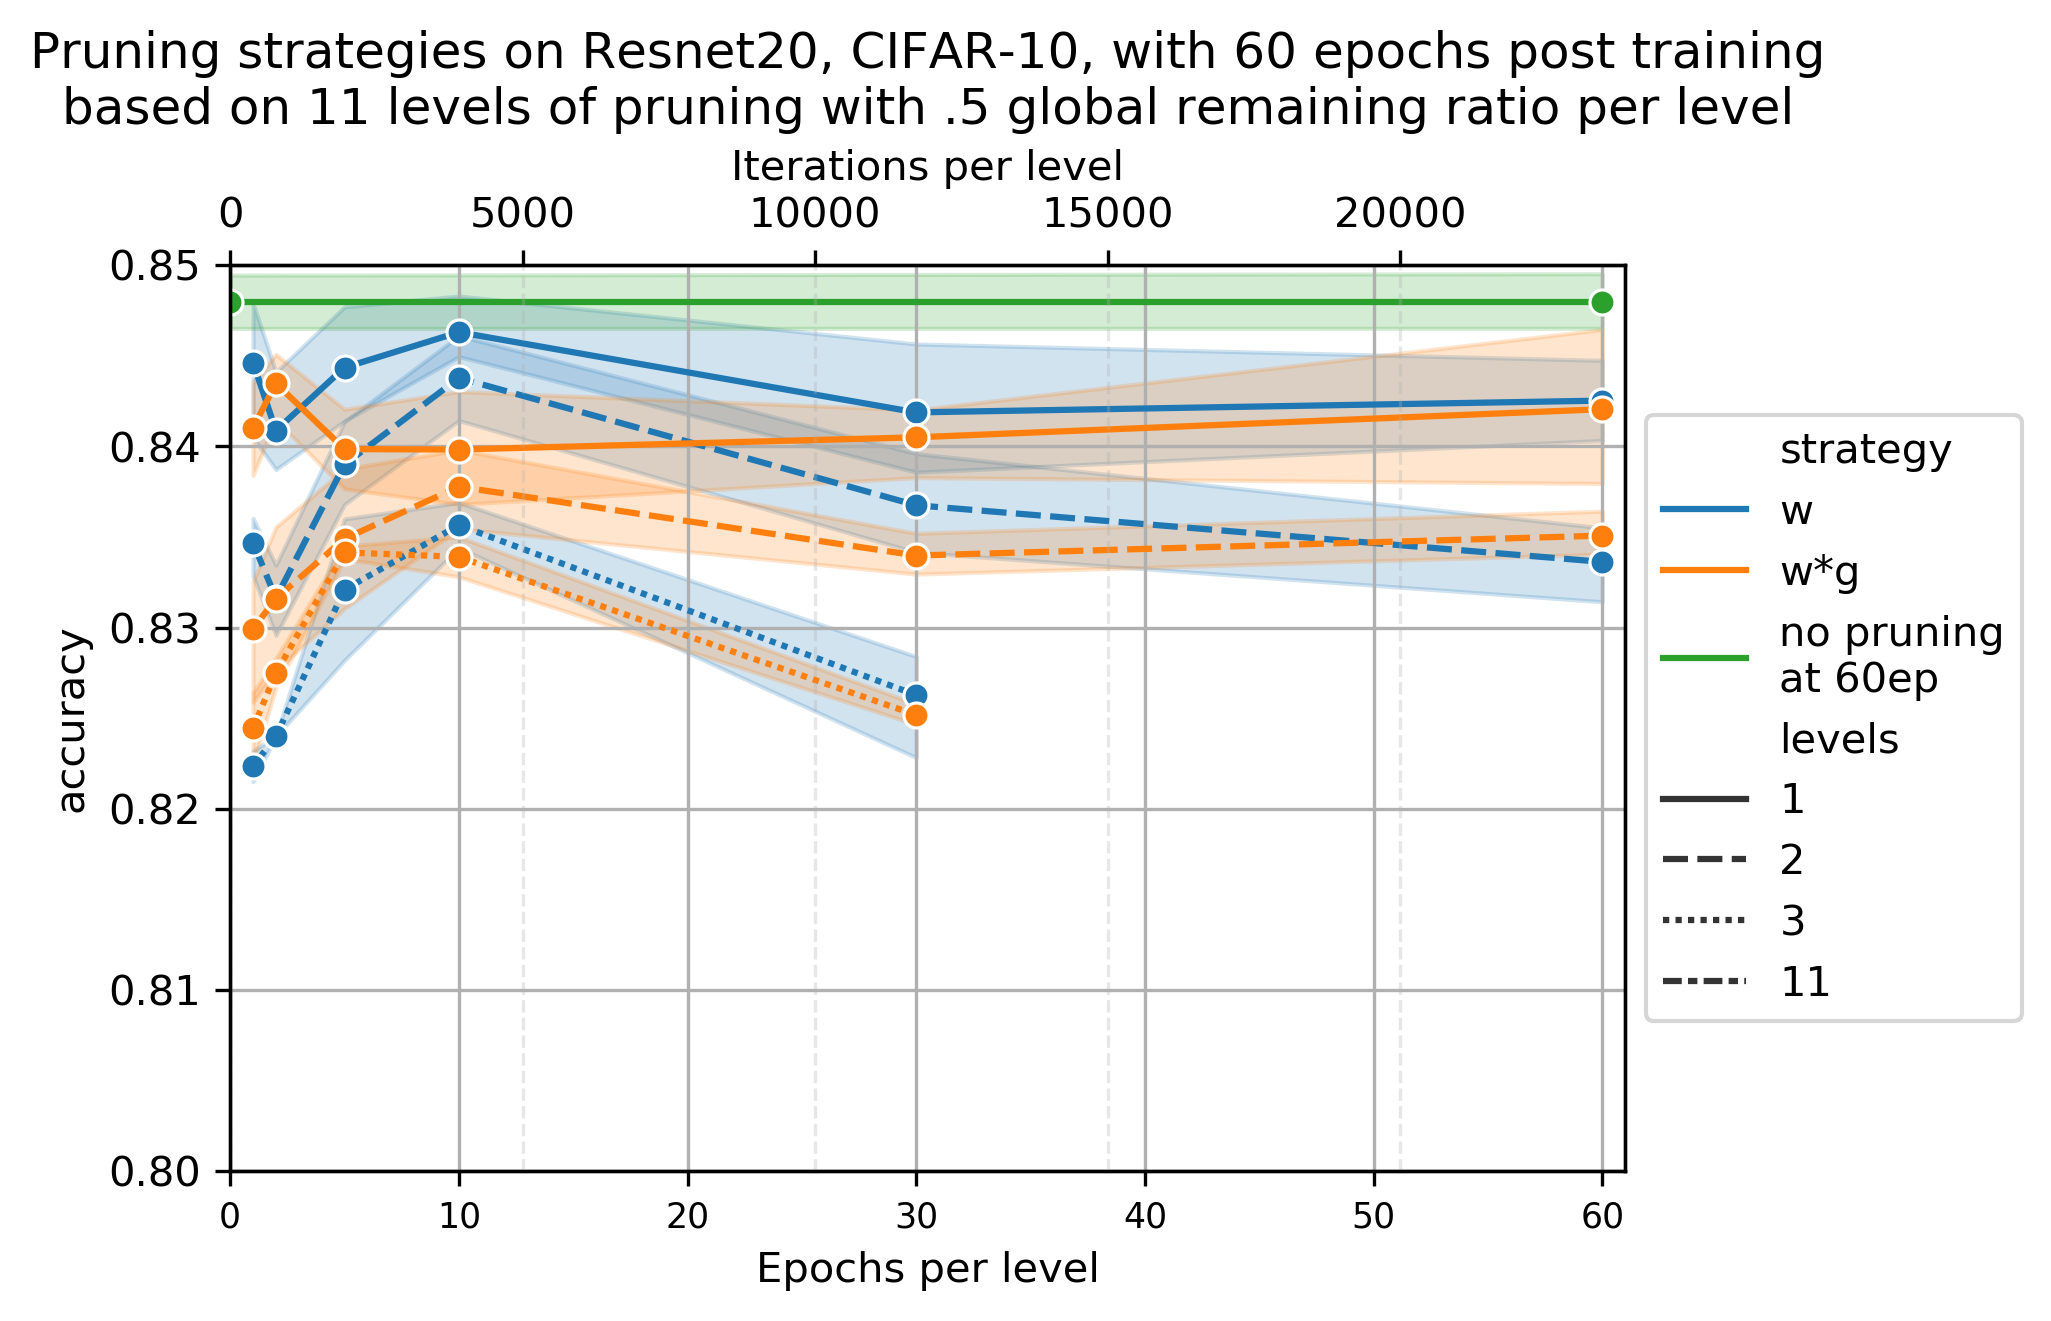

In [155]:
df = df_unfiltered.query("level == 'level_posttrain' and levels != -1").sort_values('strategy').append(baseline_nopruning_df)
plt.figure(figsize=(6,4), facecolor='white', dpi=300)
plt.tight_layout()
ax = sns.lineplot(x="epochs_per_level", y="accuracy", data=df, hue='strategy', style='levels', marker = 'o', err_style='band', err_kws={'alpha':0.2})
ax.set_title('Pruning strategies on Resnet20, CIFAR-10, with 60 epochs post training\nbased on 11 levels of pruning with .5 global remaining ratio per level')
ax.set_xlabel('Epochs per level')
ax.set_xlim((0, 61))
ax.set_ylim((0.8, 0.85))
ax.legend(loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
# ax.set_ylim((0.69, 0.81))
#ax.set_xticks(sorted(ax.get_xticks(), reverse=True))
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize('small')
    
ax.grid()
    
ax2 = ax.twiny()
ax2 = sns.lineplot(x="iters_per_level", y="accuracy", data=df, hue='strategy', marker = '', err_style=None, linewidth=0)
ax2.legend_.remove()
ax2.set_xlabel('Iterations per level')
ax2.set_xlim(np.array(ax.get_xlim())*391)
ax2.grid(axis='x', alpha = 0.3, ls = '--')
